# P5


In [1]:
import pandas as pd
import numpy as np

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')


C#
c++
.net
MISC
MISC


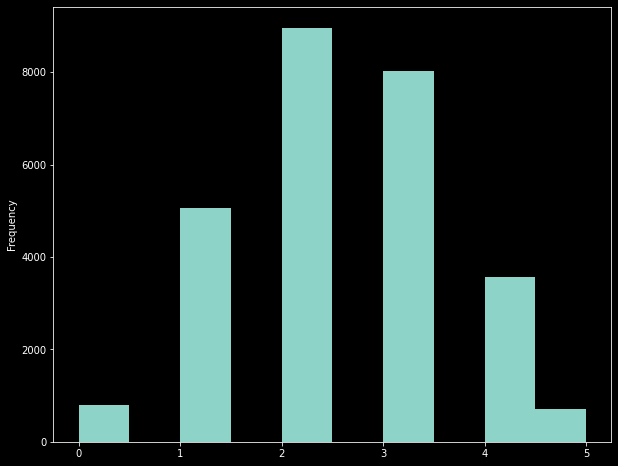

In [39]:
%run data_process.ipynb

In [2]:
with open('docs_reduced_body', 'rb') as f:
    docs_reduced_body = pickle.load(f)
    f.close()
with open('docs_reduced_body_sentences', 'rb') as f:
    docs_reduced_body_sentences = pickle.load(f)
    f.close()

with open('docs_tags', 'rb') as f:
    docs_tags = pickle.load(f)
    f.close()

with open('common_words', 'rb') as f:
    common_words = pickle.load(f)
    f.close()

with open('common_tags', 'rb') as f:
    common_tags = pickle.load(f)
    f.close()


## MultiLabel Binarizer

### Tags

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_t = MultiLabelBinarizer()
mlb_b = MultiLabelBinarizer()

def mlb_tags():
    # fit the mlb with common tags (200)
    print(f'fitting multilabel binarizer for common tags (len: {len(common_tags)})')
    mlb_t.fit([common_tags])
    print(mlb_t.classes_.shape)
    # docs['mlb_tags'] = mlb_t.transform(docs.tags).tolist()
    return mlb_t

def mlb_body():
    print(f'fitting multilabel binarizer for corpus common words (len: {len(common_words)})')
    mlb_b.fit([common_words])
    print(mlb_b.classes_.shape)
    # docs['mlb_reduced_body'] = mlb_b.transform(docs.reduced_body).tolist()
    return mlb_b
 
mlb_tags()
mlb_body()


fitting multilabel binarizer for common tags (len: 200)
(200,)


MultiLabelBinarizer()

fitting multilabel binarizer for corpus common words (len: 2066)
(2066,)


MultiLabelBinarizer()

In [4]:
# test mlb on body
test_str = 'java'
mlb_b.inverse_transform(mlb_b.transform([[test_str]]))

[('java',)]

In [5]:
docs_body_mlb = [mlb_b.transform([doc])[0] for doc in docs_reduced_body]

In [6]:

docs_tags_mlb = [mlb_t.transform([tag])[0] for tag in docs_tags]

In [7]:
text = docs_reduced_body[0]
# text

transform = mlb_b.inverse_transform(mlb_b.transform([text]))[0]
# transform

assert (text == transform[0]).sum() > 1
assert len(transform) <= len(text)

In [8]:
len(np.unique(docs_reduced_body[0]))
np.count_nonzero(docs_body_mlb[0] == 1)


45

45

In [9]:
# test mlb on tags
tags = docs_tags[0]
tags
transformed_tags = mlb_t.transform([tags])
transformed_tags
assert mlb_t.inverse_transform(transformed_tags)[0][0] == tags[0]

['javascript']

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [10]:
with open('mlb_t', 'wb') as v :
    pickle.dump(mlb_t, v)

## Bag Of Words

Bag of words uses CountVectorizer, then we look for the most frequent word to suggest a tag

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(vocabulary=common_words)
bow = cv.fit_transform(docs_reduced_body_sentences)
data_dense = bow.todense()
print("Sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsity:  1.7462819410072161 %


In [12]:

len(bow.toarray()[0])
np.count_nonzero(bow[0].toarray() > 2)
cv.get_feature_names_out()

2066

2

array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype=object)

## Train, Test Sets

In [13]:
from sklearn.model_selection import train_test_split

X = bow
y = docs_tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Dummy Classifier

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

dummy_clf.predict(X)

dummy_clf.score(X, y)


DummyClassifier(strategy='most_frequent')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

0.029268652314951342

## Tf/IdF

Tf-idf takes the frequency of a word from a sentence in a context of a corpus, then we take the most frequent words to suggest a tag

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=common_words, ngram_range=(1, 2))
# vectorizer.fit(docs.reduced_body)
vectorizer.fit(docs_reduced_body_sentences)

vectorizer.get_feature_names_out()


TfidfVectorizer(ngram_range=(1, 2),
                vocabulary=array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype='<U22'))

array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype=object)

In [36]:
with open('vectorizer', 'wb') as v :
    pickle.dump(vectorizer, v)


#### Prediction method for tf-idf

In [56]:
# predicition - nouvelle methode
# TODO optimize  - temps de calcul trop long ~ 3'30

def predict_tfidf(doc, filter_tags=True) -> list[str]:
    """
    Returns a list of tags representative to the document provided, predicted from tf-idf

    Parameters
    ----------
    doc: iterable
        a list of words to compute tf-idf
    
    filter_tags: boolean
        defines if returned tags must be part of a currated list of tags
    
    Returns
    -------
    ret : a list of strings, may be empty

    """
    res = vectorizer.transform([doc]).T.todense()
    res = pd.DataFrame({'tfidf': res.tolist()}).sort_values('tfidf', ascending=False)[:5]
    res = [ vectorizer.get_feature_names_out()[found_tag_index] for found_tag_index in res.index]    
    # print(f'found tags from tfidf: {res}')
    if (not filter_tags):
        return res
    else:
        return [tag for tag in res if tag in common_tags]


# test
index = 2
docs_reduced_body_sentences[index]
predict_tfidf(docs_reduced_body_sentences[index], False) #show all tags found
predict_tfidf(docs_reduced_body_sentences[index]) # show only tags found which are part of currated tags (list of 200)


'linq query trying perform linq query object finding performing query example allowed get something like working linq query allowed'

['linq', 'query', 'allowed', 'performing', 'finding']

['linq']

In [60]:

[predict_tfidf(doc) for doc in docs_reduced_body_sentences]


[[],
 [],
 ['linq'],
 [],
 ['file'],
 [],
 ['performance'],
 [],
 [],
 [],
 ['image'],
 ['maven'],
 ['authentication'],
 [],
 [],
 ['java'],
 ['java'],
 ['http'],
 ['memory'],
 ['tomcat', 'spring'],
 ['list'],
 ['iphone'],
 [],
 ['wpf'],
 ['inheritance'],
 ['regex', 'parsing'],
 [],
 ['git', 'xcode', 'file'],
 [],
 ['browser', 'security'],
 ['function', 'scipy'],
 [],
 [],
 ['performance', 'orm'],
 ['linq'],
 ['spring'],
 [],
 ['list', 'performance'],
 ['python', 'class'],
 ['jquery'],
 ['browser', 'html'],
 ['database'],
 [],
 ['string'],
 ['linux'],
 [],
 [],
 ['file'],
 ['shell'],
 ['url'],
 ['java'],
 ['date'],
 ['file'],
 ['string'],
 [],
 ['concurrency'],
 [],
 ['testing'],
 ['python'],
 [],
 ['inheritance'],
 [],
 [],
 ['angular', 'angularjs'],
 ['date', 'datetime', 'sql'],
 [],
 [],
 ['git'],
 ['bash'],
 ['dictionary', 'hash', 'python'],
 [],
 ['algorithm'],
 ['debugging'],
 ['video'],
 ['oop', 'class', 'javascript'],
 [],
 [],
 [],
 [],
 [],
 ['sql'],
 ['performance'],
 [],
 [

In [39]:
# compute mlb of predicted tags
# docs['mlb_tags_pred_tfidf'] = [mlb.transform([tags]) for tags in docs.predicted_tags_tfidf]
docs['mlb_tags_pred_tfidf'] = mlb_b.transform(docs.predicted_tags_tfidf).tolist()


In [40]:
len(mlb_b.classes_.tolist())
# docs.mlb_tags_pred_tfidf[0]

1102

#### Multi-label scoring

<https://medium.datadriveninvestor.com/predicting-tags-for-the-questions-in-stack-overflow-29438367261e>

<https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea>



In [90]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

# y_true = mlb_b.transform(docs.tags).tolist()
y_true = mlb_t.transform(docs_tags).tolist()
# y_pred = mlb_b.transform(docs.predicted_tags_tfidf).tolist()
y_pred = mlb_t.transform([predict_tfidf(doc) for doc in docs_reduced_body_sentences]).tolist()


In [91]:

accuracy_score(y_true, y_pred)
average_precision_score(y_true, y_pred)
# recall_score(y_true, y_pred, average='macro')
print(classification_report(y_true, y_pred, target_names=mlb_t.classes_))

0.06307136537894427

0.17578955260659554

                        precision    recall  f1-score   support

                  .net       0.00      0.00      0.00      1402
                  ajax       0.80      0.41      0.54       318
             algorithm       0.63      0.26      0.36       474
   amazon-web-services       0.00      0.00      0.00       138
               android       0.95      0.27      0.42      1994
        android-layout       0.00      0.00      0.00       158
        android-studio       0.00      0.00      0.00       185
               angular       0.61      0.53      0.57       173
             angularjs       0.95      0.36      0.52       264
             animation       0.48      0.54      0.51       112
                apache       0.57      0.37      0.45       167
          apache-spark       0.00      0.00      0.00       166
      apache-spark-sql       0.00      0.00      0.00        99
                   api       0.22      0.46      0.30       147
          architecture       0.19      

### Conclusion

Using tf-idf is not really performant to predict relevant tags (F1 score is way lower than 1)

| Score | value|
|--------|-------|
| Precision score | 0.43|
| Recall score | 0.25|
| f1-score | 0.28|




average parameter is required for multiclass/multilabel targets.


'None' : the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.




Plus le recall est haut, plus le modèle repère de positif.

Plus la precision est haute, moins le modèle se trompe sur les positifs

Le F1 Score permet d’effectuer une bonne évaluation de la performance de notre modèle

reminder : <https://inside-machinelearning.com/recall-precision-f1-score/>

## LDA

<https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d>

<https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#7createthedocumentwordmatrix>

In [42]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=1000, random_state=0, n_jobs=-1)
lda.fit(bow)

LatentDirichletAllocation(n_components=1000, n_jobs=-1, random_state=0)

In [43]:
def list_lda_topics() :
	for idx, topic in enumerate(lda.components_):
		print ("Topic ", idx, " ".join(cv.get_feature_names()[i] for i in topic.argsort()[:-3 -1:-1]))

# list_lda_topics()

In [44]:
def predict_lda(text):
    best_topic_indexes = lda.transform(cv.transform([text])).argsort()[0][::-1][0]
    # print(f'lda best topic index found: {best_topic_indexes}')
    best_topics = lda.components_[best_topic_indexes].argsort()[::-1]
    # print(f'topic\'s word indexes {best_topics[:1]}')
    ret = [cv.get_feature_names()[topic] for topic in best_topics[:1]]
    # print(f'predicted tag: {ret}')
    return ret

In [45]:
# some indexes that work, otherwise most of the time predicted tag is wrong
# index = 7894
index = 1250

text = docs.reduced_body[index]
print(f'input text: {text}')
print(f'known tags: {docs.tags[index]}')

predict_lda(text)


input text: bit x machine code like first byte x disk file using suggestion linux file
known tags: ['linux', 'assembly', 'x86']


['linux']

### LDA Scoring

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

MAX_COUNT = 1000
y_true = mlb_t.transform(docs.tags[:MAX_COUNT])
y_pred = mlb_t.transform([predict_lda(text) for text in docs.reduced_body[:MAX_COUNT]])

accuracy_score(y_true, y_pred)
average_precision_score(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=mlb_t.classes_))

0.027

nan

                        precision    recall  f1-score   support

                  .net       0.00      0.00      0.00       103
                  ajax       1.00      0.25      0.40        16
             algorithm       0.58      0.21      0.31        33
   amazon-web-services       0.00      0.00      0.00         0
               android       1.00      0.08      0.14        26
        android-layout       0.00      0.00      0.00         2
        android-studio       0.00      0.00      0.00         3
               angular       0.00      0.00      0.00         1
             angularjs       1.00      0.17      0.29         6
             animation       0.33      0.33      0.33         3
                apache       0.00      0.00      0.00         3
          apache-spark       0.00      0.00      0.00         1
      apache-spark-sql       0.00      0.00      0.00         1
                   api       0.00      0.00      0.00         4
          architecture       0.00      

In [47]:
from sklearn.metrics import multilabel_confusion_matrix

matrix = multilabel_confusion_matrix(y_true, y_pred, samplewise=False)
for idx, label in enumerate(mlb_t.classes_):
    print(f'{label} :\n TN:{matrix[idx][0,0]}\tFN:{matrix[idx][1,0]}\tTP:{matrix[idx][1,1]}\tFP:{matrix[idx][0,1]}')

.net :
 TN:897	FN:103	TP:0	FP:0
ajax :
 TN:984	FN:12	TP:4	FP:0
algorithm :
 TN:962	FN:26	TP:7	FP:5
amazon-web-services :
 TN:1000	FN:0	TP:0	FP:0
android :
 TN:974	FN:24	TP:2	FP:0
android-layout :
 TN:998	FN:2	TP:0	FP:0
android-studio :
 TN:997	FN:3	TP:0	FP:0
angular :
 TN:997	FN:1	TP:0	FP:2
angularjs :
 TN:994	FN:5	TP:1	FP:0
animation :
 TN:995	FN:2	TP:1	FP:2
apache :
 TN:997	FN:3	TP:0	FP:0
apache-spark :
 TN:999	FN:1	TP:0	FP:0
apache-spark-sql :
 TN:999	FN:1	TP:0	FP:0
api :
 TN:995	FN:4	TP:0	FP:1
architecture :
 TN:997	FN:2	TP:0	FP:1
arrays :
 TN:986	FN:14	TP:0	FP:0
asp.net :
 TN:967	FN:33	TP:0	FP:0
asp.net-core :
 TN:997	FN:3	TP:0	FP:0
asp.net-mvc :
 TN:986	FN:14	TP:0	FP:0
asp.net-mvc-3 :
 TN:1000	FN:0	TP:0	FP:0
asp.net-mvc-4 :
 TN:999	FN:1	TP:0	FP:0
asp.net-web-api :
 TN:996	FN:4	TP:0	FP:0
assembly :
 TN:988	FN:8	TP:1	FP:3
async-await :
 TN:1000	FN:0	TP:0	FP:0
asynchronous :
 TN:996	FN:3	TP:0	FP:1
audio :
 TN:997	FN:3	TP:0	FP:0
authentication :
 TN:993	FN:6	TP:1	FP:0
bash :
 TN:986	

## Supervised Classifier Model

### Supervised classifier - BoW + LogisticRegression

In [15]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

# TODO WIP
# clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10), n_jobs=30).fit(X_train, y_train)

In [16]:

# or OneVsRest classifier instead

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

LOGISTIC_REGRESSION_PARAMETERS = {'C': 0.1, 'max_iter': 100, 'n_jobs': -1}

# todo faire un grid search cv

clf = OneVsRestClassifier(LogisticRegression(**LOGISTIC_REGRESSION_PARAMETERS)).fit(X_train, y_train)


In [17]:
with open('classifier', 'wb') as v :
    pickle.dump(clf, v)

In [18]:
predictions = clf.predict(X_test)
predictions

pred = predictions[1].reshape(1, -1)
# need to reshape prediction to have a matrix of 1 sample with n classes
mlb_t.inverse_transform(pred.reshape(1, -1))


cv.inverse_transform(X_test[1])
mlb_t.inverse_transform(y_test[1].reshape(1, -1))

# all the 
mlb_t.inverse_transform(predictions)
mlb_t.inverse_transform(np.array(y_test))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

[('angularjs', 'css', 'html', 'javascript', 'twitter-bootstrap')]

[array(['angular', 'angularjs', 'another', 'app', 'best', 'bootstrap',
        'called', 'code', 'combine', 'cover', 'directive', 'done', 'first',
        'get', 'however', 'like', 'look', 'nt', 'original', 'place',
        'project', 'seems', 'three', 'twitter', 'way', 'web', 'would',
        'written'], dtype='<U22')]

[('angularjs', 'javascript', 'twitter-bootstrap')]

[(),
 ('angularjs', 'css', 'html', 'javascript', 'twitter-bootstrap'),
 ('android',),
 ('exception', 'java', 'logging', 'spring', 'spring-boot'),
 (),
 (),
 ('google-chrome',),
 (),
 ('ajax',),
 ('lambda',),
 (),
 ('iphone', 'objective-c', 'ssl'),
 ('java',),
 ('ruby', 'ruby-on-rails'),
 ('ios', 'iphone', 'video'),
 (),
 (),
 (),
 (),
 (),
 (),
 ('css', 'html', 'javascript', 'jquery', 'twitter-bootstrap'),
 (),
 ('android', 'php'),
 (),
 (),
 ('c#', 'ios', 'objective-c'),
 ('css', 'html'),
 (),
 ('android', 'animation'),
 ('dictionary', 'java'),
 (),
 ('bash', 'shell'),
 ('php',),
 (),
 ('c++', 'concurrency', 'multithreading'),
 ('python',),
 ('c++', 'design-patterns', 'inheritance', 'xaml'),
 ('c++',),
 ('user-interface',),
 ('angularjs', 'javascript'),
 ('ios',),
 ('bash', 'linux', 'shell', 'terminal', 'ubuntu', 'unix'),
 (),
 (),
 ('css', 'html', 'javascript', 'jquery'),
 ('c++', 'css'),
 ('c++',),
 (),
 (),
 (),
 ('animation', 'ios'),
 (),
 (),
 ('html', 'windows'),
 ('flutter',),


[('c++', 'hash'),
 ('angularjs', 'javascript', 'twitter-bootstrap'),
 ('algorithm', 'android'),
 ('java', 'spring', 'spring-boot', 'spring-mvc', 'tomcat'),
 ('assembly',),
 ('java', 'maven', 'spring', 'spring-boot'),
 ('google-chrome', 'javascript'),
 ('flutter',),
 ('ajax', 'authentication', 'ruby-on-rails'),
 ('.net', 'c#', 'events', 'lambda'),
 ('c#',),
 ('ios', 'iphone', 'ssl'),
 ('java', 'multithreading'),
 ('ruby', 'ruby-on-rails', 'ubuntu'),
 ('image-processing', 'ios', 'iphone'),
 ('ios', 'swift', 'uitableview'),
 ('ios', 'iphone', 'multithreading'),
 ('installation', 'sql-server'),
 ('c++', 'c++11', 'stl'),
 ('.net', 'wpf', 'xaml'),
 ('android',),
 ('css', 'html', 'javascript'),
 (),
 ('android', 'api', 'java'),
 ('css', 'javascript', 'jquery'),
 ('git', 'github', 'ruby-on-rails'),
 ('ios', 'iphone', 'objective-c'),
 ('animation', 'css', 'html', 'javascript', 'jquery'),
 (),
 ('android',),
 ('java',),
 ('cocoa', 'iphone', 'objective-c', 'uiview'),
 ('command-line', 'linux', 's

In [33]:
def predict_supervised(doc):
    """
    Considers doc is already tokenized

    requires classifier
    requires multibinary transformer
    """
    prediction = clf.predict(doc)
    return mlb_t.inverse_transform(prediction.reshape(1, -1))

### Scoring

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import multilabel_confusion_matrix

y_true = np.array(y_test)
y_pred = predictions

accuracy_score(y_true, y_pred)
average_precision_score(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=mlb_t.classes_))

0.11844206905025187

0.19902526670420012

                        precision    recall  f1-score   support

                  .net       0.51      0.19      0.28       405
                  ajax       0.68      0.29      0.40        98
             algorithm       0.66      0.34      0.45       140
   amazon-web-services       0.80      0.27      0.41        44
               android       0.96      0.71      0.81       610
        android-layout       0.44      0.16      0.24        50
        android-studio       0.64      0.41      0.50        56
               angular       0.72      0.53      0.61        43
             angularjs       0.79      0.39      0.52        95
             animation       0.47      0.25      0.33        32
                apache       0.68      0.25      0.37        52
          apache-spark       0.91      0.51      0.66        41
      apache-spark-sql       0.43      0.26      0.32        23
                   api       0.31      0.08      0.13        50
          architecture       0.08      

## Word2Vect

In [62]:
# snippet taken from sample notebook
import gensim
import multiprocessing
from gensim.models import Word2Vec

# sentences = [ docs.split() for docs in docs.reduced_body]
sentences = [ docs.split() for docs in common_words]

print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(sentences, min_count=1,vector_size=MAX_TAGS, workers=multiprocessing.cpu_count())
# w2v_model.build_vocab(sentences)
# w2v_model.train(sentences, total_examples=1, epochs=1)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2066
Word2Vec trained


In [63]:
# training another model, will give slightly different results

model = Word2Vec(sentences, min_count=1, vector_size=MAX_TAGS, workers=multiprocessing.cpu_count())
# model.build_vocab(sentences)
# model.train(sentences, total_examples=1, epochs=1)
# model.wv.index_to_key
print("Vocabulary size: %i" % len(model.wv.index_to_key))

Vocabulary size: 2066


In [64]:
# guess close words
len(model.wv.index_to_key)
guess = 'java'
model.wv[guess]
model.wv.most_similar(guess)
# w2v_model.wv[guess]
w2v_model.wv.most_similar(guess)

2066

array([ 1.19479303e-03,  1.90154905e-03,  4.37673926e-03,  4.96896508e-04,
       -3.42740654e-03,  2.14081653e-03, -4.71070409e-03, -1.20294932e-03,
       -4.09509661e-03, -3.91142350e-03, -2.62419344e-03,  4.32805298e-03,
       -3.62711539e-03,  8.24775721e-04,  2.33565574e-03,  1.50928495e-03,
        4.53167781e-03, -3.30674637e-04, -1.60668965e-03,  1.31942041e-04,
       -1.36909005e-03,  4.23071999e-03,  3.09684523e-03,  2.00022571e-03,
       -4.12234897e-03,  3.35534802e-04, -6.27405650e-04, -2.56343489e-03,
        9.52060218e-04,  3.56034283e-03,  2.18310230e-03, -1.13163714e-03,
        1.25624542e-03, -1.77154783e-03, -1.60435203e-03,  3.18522681e-03,
        7.76642584e-04, -4.95906360e-03, -1.06799486e-03,  1.24902721e-03,
       -4.71557723e-03, -3.04148905e-03,  2.43263016e-03,  1.36838073e-03,
       -2.58088345e-03, -2.37775571e-03, -2.11625220e-03, -2.71165372e-05,
        1.31694193e-03,  2.54357466e-03,  3.40255862e-03, -3.95598868e-03,
       -2.79505970e-03, -

[('cycle', 0.18776032328605652),
 ('svn', 0.1852821558713913),
 ('low', 0.18308457732200623),
 ('front', 0.17848826944828033),
 ('couple', 0.17821882665157318),
 ('await', 0.17766311764717102),
 ('asp.net-web-api', 0.17678077518939972),
 ('pro', 0.172426238656044),
 ('language', 0.1708361804485321),
 ('requirement', 0.1695408821105957)]

[('cycle', 0.18776032328605652),
 ('svn', 0.1852821558713913),
 ('low', 0.18308457732200623),
 ('front', 0.17848826944828033),
 ('couple', 0.17821882665157318),
 ('await', 0.17766311764717102),
 ('asp.net-web-api', 0.17678077518939972),
 ('pro', 0.172426238656044),
 ('language', 0.1708361804485321),
 ('requirement', 0.1695408821105957)]

In [65]:
with open('w2v_model', 'wb') as v :
    # pickle.dump(w2v_model, v)
    w2v_model.save(v)


### Averaged vector for documents

In [67]:
# compute average vector for each document
averaged_docs = [np.mean([w2v_model.wv[word] for word in doc.split()], axis=0) for doc in docs_reduced_body_sentences ]
# averaged_docs
# docs['wv_averaged_doc'] = averaged_docs
# averaged_docs

In [68]:
# todo wip document vectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs_reduced_body_sentences)]
d2v_model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=multiprocessing.cpu_count())

In [69]:
vector = d2v_model.infer_vector([docs_reduced_body_sentences[0]])
vector

array([-8.3779404e-03,  4.9861576e-03, -8.0547491e-03, -9.0661226e-04,
       -8.5489247e-03, -5.3092898e-03,  9.7957812e-03, -5.4900111e-03,
        7.8452313e-03,  8.8752555e-03, -6.0835113e-03,  3.0598533e-03,
        9.5206629e-03,  3.3074140e-04, -1.2701272e-04, -2.5362808e-03,
        7.5544310e-03,  9.4492864e-03, -9.6961819e-03, -3.1682252e-05,
       -8.0832168e-03, -7.3841809e-05, -4.1732700e-03,  1.1601329e-04,
       -2.6441538e-03,  7.9966644e-03, -4.3143779e-03, -2.3189199e-03,
       -7.2746696e-03, -9.1830865e-03, -5.3754328e-03, -8.5684182e-03,
       -9.2908265e-03, -1.3884031e-03, -7.0761358e-03,  3.8664639e-03,
       -3.6982906e-03,  2.6572871e-03,  5.0904346e-03, -3.5754209e-03,
       -8.4950542e-03, -7.1399049e-03,  1.6066980e-03,  6.4066029e-03,
       -6.4675063e-03,  7.8407144e-03, -1.9589949e-03,  3.8621246e-03,
       -5.1891785e-03, -1.9990874e-03], dtype=float32)

In [70]:
d2v_model.dv.vectors

array([[-0.05303331, -0.11346034,  0.08324888, ..., -0.03700346,
         0.1267366 ,  0.04415212],
       [ 0.11819981, -0.00347143, -0.06782736, ..., -0.22460695,
        -0.12143703,  0.09418076],
       [ 0.15909176, -0.42773113, -0.08026198, ..., -0.32317573,
         0.11893296,  0.02130418],
       ...,
       [ 0.072847  , -0.03101841, -0.00186609, ..., -0.00223558,
         0.03244439, -0.02967012],
       [-0.00346273, -0.07897745,  0.08235946, ..., -0.10149726,
         0.12927927, -0.0244991 ],
       [-0.07168326, -0.10585309,  0.07323122, ...,  0.08573978,
         0.10954352,  0.07371448]], dtype=float32)

### Clusterize embeded documents

In [71]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=MAX_TAGS, random_state=0).fit(d2v_model.dv.vectors.astype('double'))


In [72]:
len(averaged_docs)
len(averaged_docs[0])
kmeans.labels_
kmeans.labels_.min()
kmeans.labels_.max()


27128

200

array([ 89,  54,  74, ...,  69,  88, 192], dtype=int32)

0

199

In [81]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def plot_tsne(X_tsne):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], loc="best", title="Clusters")
    plt.title('Représentation des documents par clusters')
    plt.show()


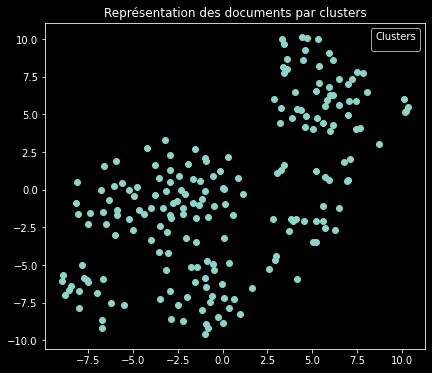

In [82]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
X_ts = tsne.fit_transform(kmeans.cluster_centers_)
plot_tsne(X_ts)


In [88]:


def show_cluster_terms(model, kmeans):
    """
    :param model: model.wv or model.dv
    :return:
    """
    print("Most representative terms per cluster (based on centroids):")
    for i in range(50):
        tokens_per_cluster = ""
        most_representative = model.most_similar(positive=[kmeans.cluster_centers_[i]], topn=1)
        for t in most_representative:
            tokens_per_cluster += f"{docs_tags[t[0]]} "
        print(f"Cluster {i}: {tokens_per_cluster}")


In [80]:
d2v_model.dv.most_similar(positive=kmeans.cluster_centers_[0], topn=1)

[(21223, 0.8435673713684082)]

In [83]:
d2v_model.dv[21223]

array([-0.00113109, -0.0652364 ,  0.0851429 ,  0.21426621,  0.15484193,
        0.02241835,  0.10394178,  0.06819127, -0.21076922, -0.19289845,
        0.25884435,  0.20742531,  0.11731138,  0.10806659,  0.12168026,
        0.01466013, -0.06444034, -0.09450842, -0.04816094,  0.02561924,
        0.10653004, -0.3118473 ,  0.08527856, -0.15704113, -0.05035762,
       -0.06314838, -0.34831312,  0.23583315,  0.00646227, -0.33026168,
        0.22313699,  0.08160243, -0.2611896 , -0.06085279,  0.13692145,
       -0.00438536, -0.2558962 , -0.1403686 , -0.11046275, -0.11939538,
        0.02482858, -0.03469988,  0.30358037,  0.01011413,  0.33313853,
        0.03251803, -0.07100293, -0.27922618, -0.11904919, -0.08512657],
      dtype=float32)

In [86]:
len(d2v_model.dv)
docs_reduced_body_sentences[21223]
docs_tags[21223]

27128

'python loop numpy array aware several question answer topic nt found answer particular problem easiest way simple python loop numpy array function looking efficient way wanted something simple implement nt require significant rewrite loop run parallel like implement lower level language best answer ve seen regard one rather way requires one express loop function take single argument several line converting seems require parallel function called main nt seem work well prompt lot time python really best way loop really something trivial read documentation module find general seems everything simple loop interested setting manager proxy pipe etc simple loop fully parallel nt communication task using simple situation seems like mention would case nt time learn different parallel package python wondering someone experience show simpler way please suggest technique already use using parallel function case general parallel'

['python', 'numpy']

In [89]:
show_cluster_terms(d2v_model.dv, kmeans)

Most representative terms per cluster (based on centroids):
Cluster 0: ['python', 'numpy'] 
Cluster 1: ['ios', 'swift'] 
Cluster 2: ['android', 'ios', 'swift', 'gradle', 'build'] 
Cluster 3: ['ruby-on-rails', 'ruby', 'json', 'http'] 
Cluster 4: ['c++', 'templates', 'c++11'] 
Cluster 5: ['javascript', 'jquery', 'html'] 
Cluster 6: ['mysql', 'sql', 'string'] 
Cluster 7: ['c#', '.net', 'caching'] 
Cluster 8: ['c++', 'c'] 
Cluster 9: ['c++', 'performance', 'optimization'] 
Cluster 10: ['python', 'selenium'] 
Cluster 11: ['objective-c', 'cocoa'] 
Cluster 12: ['html', 'css', 'list'] 
Cluster 13: ['java', 'string'] 
Cluster 14: ['android', 'performance'] 
Cluster 15: ['multithreading'] 
Cluster 16: ['python'] 
Cluster 17: ['javascript', 'loops', 'object'] 
Cluster 18: ['python', 'list'] 
Cluster 19: ['python', 'python-3.x', 'django'] 
Cluster 20: ['ios', 'image', 'uikit'] 
Cluster 21: ['c#', 'wpf', 'multithreading', 'linq'] 
Cluster 22: ['angularjs', 'file'] 
Cluster 23: ['r'] 
Cluster 24: ['

In [ ]:
# TODO WIP 
# predict
# classify ?
# faire une reduction de dimension PCA ?

# sentence = ["topic", "python"]
# sentence = docs.reduced_body[789]
# sentence

# sentence_vector = np.mean([w2v_model.wv[w2v_model.wv.most_similar(word)[0][0]] for word in sentence], axis=0)
# sentence_vector


In [ ]:
def get_most_similar_doc(sentence_vector):
    kmeans.predict([sentence_vector])
    sentence_cluster = kmeans.transform([sentence_vector])
    most_similar = kmeans.cluster_centers_[7]
    predicted_cluster = d2v_model.dv.most_similar(most_similar)
    return docs.reduced_body[predicted_cluster[0][0]], docs.tags[predicted_cluster[0][0]]


sentence = docs.reduced_body[789]
sentence
sentence_vector = d2v_model.infer_vector([sentence])
d, t = get_most_similar_doc(sentence_vector)
d
t

'java requires regex actually replace recently noticed regex come example consider string string text want replace give output exception want implement functionality need write one difference argument regex replace argument work exactly equivalent even behavior try input let text three give output java really regex best possible way feel language seems behavior regex specific reason java like'

'insert value text box input using python selenium following html structure trying use selenium value code written get element'

['python', 'python-2.7']

In [ ]:

most_similar_doc = d2v_model.dv.most_similar(0)
most_similar_doc

[(16659, 0.9060407280921936),
 (10297, 0.8768606781959534),
 (2808, 0.8715261816978455),
 (18993, 0.8709255456924438),
 (16415, 0.8664482235908508),
 (18745, 0.8642286062240601),
 (4898, 0.8561311960220337),
 (11447, 0.8492940068244934),
 (7860, 0.8481487035751343),
 (895, 0.845656156539917)]

## Appendix

sample:

<https://www.analyticsvidhya.com/blog/2021/09/onevsrest-classifier-for-predicting-multiple-tags-of-research-articles/#h2_2>



à lire


topic modelling : unsupervised learning

topic classification : supervised learning


<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/>

<https://www.baeldung.com/cs/ml-word2vec-topic-modeling>

<https://medium.com/le-blog-de-lapprentissage-automatique/pr%C3%A9diction-des-tags-des-questions-de-stack-overflow-9be00f7672f9>

Topic Modeling: Predicting Multiple Tags of Research Articles using OneVsRest strategy:
<https://www.analyticsvidhya.com/blog/2021/09/onevsrest-classifier-for-predicting-multiple-tags-of-research-articles/#h2_2>

Baeldung: Topic Modeling with Word2Vec
<https://www.baeldung.com/cs/ml-word2vec-topic-modeling>

Evaluating Multi-label Classifiers
<https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea>


Difference stemming lemmatization
<https://fr.quora.com/Quelle-est-la-diff%C3%A9rence-entre-le-stemming-et-la-lemmatisation>
